# <center>Simulación Polarímetro

**Autores**: Joaquín Andrés Porras

**Fecha**:   01/12/2024

**Motivación**: Proyecto VDOEST, Proyecto TELURO, Polarímetro de Mueller

**Objetivo**: Calibración de un polarímetro de Mueller para una longitud de onda concreta

---

## Carga de módulos y variables iniciales

### Módulos

In [1]:
# Autorreload
%load_ext autoreload
%autoreload 2

In [2]:
# Modules imported for the script
import os                                                                   # OS - Paths
import numpy as np                                                          # Numpy - Arrays
import matplotlib.pyplot as plt                                             # Matplotlib - Plot
from spectral_polarimeter_2 import SpectralPolarimeterCalibration as cal    # Calibration - Spectral Polarimeter
from spectral_polarimeter_2 import SpectralPolarimeter as sp                # Spectral Polarimeter
from py_lab.utils import degrees                                            # Utils - Degrees
from py_pol.mueller import Mueller                                          # Mueller
from py_pol.stokes import Stokes                                            # Stokes
import py_lab.utils as utils                                                # Utils py-lab

2024-10-19 19:16:42,055 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [3]:
# Get the current path
ruta = os.getcwd()

### Variables

In [4]:
# Select the wavelength
wavelength = 632

In [5]:
# Create the calibration object and load the calibration files
cal_dict = cal.Create_Cal_Files(single = True, wavelengths = wavelength)

---

##  Configuración inicial

In [6]:
# CASO IDEAL

S0 = Stokes().general_azimuth_ellipticity(
                intensity = 1,
                azimuth= 0 * degrees,
                ellipticity= 0 * degrees,
                degree_pol = 1)

Mr0 = Mueller().diattenuator_retarder_linear(
                p1= 1, p2 = 1, R = 90 * degrees, azimuth= S0.parameters.azimuth() + 45 * degrees)

S1 = Mr0 * S0

Mp1 = Mueller().diattenuator_retarder_azimuth_ellipticity(
                p1 = 1, p2 = 0, azimuth = 0 * degrees, R = 0 * degrees)
Mr1 = Mueller().diattenuator_retarder_linear(
                p1 = 1, p2 = 1, R = 90 * degrees, azimuth= 0 * degrees)

Mr2 = Mueller().diattenuator_retarder_linear(
                p1 = 1, p2 = 1, R = 90 * degrees, azimuth= 0 * degrees)
Mp2 = Mueller().diattenuator_retarder_azimuth_ellipticity(
                p1 = 1, p2 = 0, azimuth = 0 * degrees, R = 0 * degrees)
# Mp2 = Mp1

Mpc = Mueller().diattenuator_retarder_azimuth_ellipticity(
                p1 = 1, p2 = 0, azimuth = 0 * degrees, R = 0 * degrees)
Mrc = Mueller().diattenuator_retarder_linear(
                p1 = 1, p2 = 1, R = 90 * degrees, azimuth = 45 * degrees)

angles_def = np.linspace(0,180,361)
            

In [7]:
# CASO REAL

S0 = Stokes().general_azimuth_ellipticity(
                intensity = 1,
                azimuth= 0 * degrees,
                ellipticity= 0 * degrees,
                degree_pol = 1)

Mr0 = Mueller().diattenuator_retarder_linear(
                p1= 1, p2 = 1, R = 90 * degrees, azimuth= S0.parameters.azimuth() + 45 * degrees)

S1 = Mr0 * S0

Mp1 = Mueller().diattenuator_retarder_azimuth_ellipticity(
                p1 = 1, p2 = 0.02, azimuth = -10 * degrees, R = 60 * degrees)
Mr1 = Mueller().diattenuator_retarder_linear(
                p1 = 1, p2 = 1, R = 90 * degrees, azimuth= -35 * degrees)

Mr2 = Mueller().diattenuator_retarder_linear(
                p1 = 1, p2 = 1, R = 90 * degrees, azimuth= -45 * degrees)
# Mp2 = Mueller().diattenuator_retarder_azimuth_ellipticity(
                # p1 = 0.96, p2 = 0.02, azimuth = -25 * degrees, R = 90 * degrees)
Mp2 = Mp1

Mpc = Mueller().diattenuator_retarder_azimuth_ellipticity(
                p1 = 1, p2 = 0, azimuth = 0 * degrees, R = 0 * degrees)
Mrc = Mueller().diattenuator_retarder_linear(
                p1 = 1, p2 = 1, R = 90 * degrees, azimuth = 45 * degrees)

angles_def = np.linspace(0,180,361)
            

---

## Paso 0: Iluminación

### Paso 0a: Polarizador P0

Colocamos el polarizador P0 en el ángulo en el cual la intensidad a la salida sea máxima. No tiene por qué coincidir con el eje X del laboratorio (lo que equivale a un azimut de 0°). 

Luego, colocamos el polarizador 1 y lo rotamos 180°. Donde salga la intensidad máxima, obtendremos el ángulo de P0 respecto al sistema de referencia de P1 (lo llamamos P0_az). Lo necesitaremos para los pasos más adelante

In [8]:
# Medida experimental paso 0a
Mp1_rot = Mp1.rotate(angle = angles_def * degrees, keep = True)
Sf = (Mp1_rot * S0)
Iexp_0a = Sf.parameters.intensity()
angles_0a = angles_def * degrees

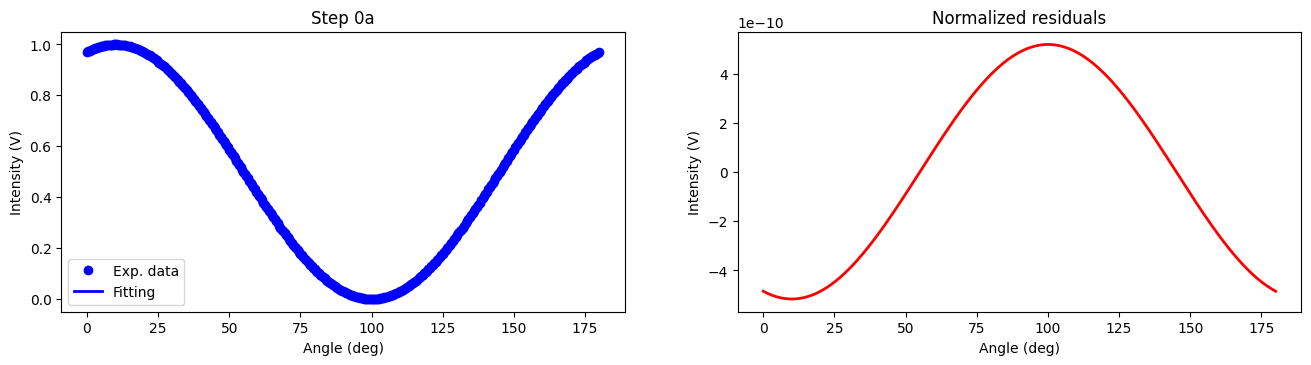

The normalized MSE is: 0.00 %.

The values obtained are:
   - Imax       : 1.0000 V
   - Imin       : 0.0004 V
   - Maximum angle : 10.00 deg


In [9]:
# Análisis paso 0a
result = cal.analyze_step(step = '0a', cal_dict = cal_dict, Iexp = Iexp_0a, angles = angles_0a, single = True)
cal_dict['P0_az'] = result[2]
cal_dict['S0'] = S0.parameters.intensity()

### Paso 0b: Colocación del retardador Q0

A continuación, tenemos que colocar el retardador R0 de tal modo que a la salida del sistema óptico obtengamos polarización circular o lo más parecido posible. Para conseguir polarización circular, el retardador tiene que estar colocado a 45° con respecto al polarizador P0. 

Una vez conseguido, medimos tanto el azimut como la elipticidad de la fuente, y lo guardamos en el diccionario

In [10]:
# Medida experimental paso 0b
Mp1_rot = Mp1.rotate(angle = angles_def * degrees, keep = True)
Sf = (Mp1_rot * S1)
Iexp = Sf.parameters.intensity()

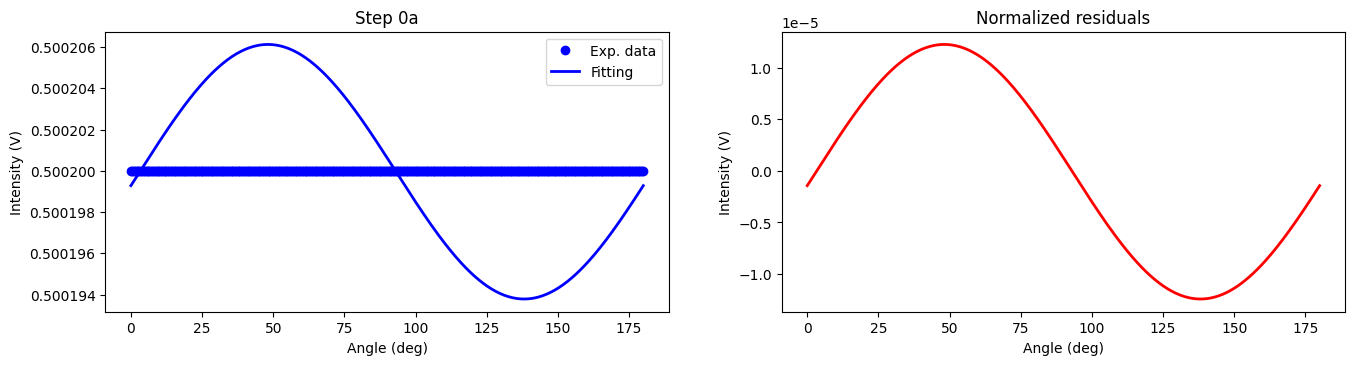

The normalized MSE is: 0.00 %.

The values obtained are:
   - Imax       : 0.5002 V
   - Imin       : 0.5002 V
   - Maximum angle : 48.14 deg

   - Ellipticity angle:  [45.] degrees
   - Azimuth angle:  [0.] degrees


In [11]:
# Análisis paso 0b
result = cal.analyze_step(step = '0a', cal_dict = cal_dict, Iexp = Iexp, angles = angles_def * degrees, single = True)
print("\n   - Ellipticity angle: ", np.round(cal_dict['illum_el'] / degrees, 3), "degrees")
print("   - Azimuth angle: ", np.round(cal_dict['illum_az'] / degrees, 2), "degrees")
# Guardado de los datos
cal_dict['illum_el'] = np.arctan(np.sqrt(result[0] / (result[0] + result[1])))
cal_dict['illum_az'] = result[2]
cal_dict['S1'] = S1.parameters.intensity()

---

## Paso 1: Medidas de polarizadores

A continuación, utilizamos un polarizador Pc de referencia con azimut de 0° y los dos polarizadores P1 y P2 del polarímetro. El objetivo es medir, mediante una ley de Malus dos a dos, los parámetros p1 de los polarizadores (asociados a transmisión máxima) y los azimut de P1 y P2 con respecto al sistema de referencia de los motores. 

Calculamos primero el valor máximo de la iluminación, $I_0\cdot cos^2(\alpha)$

In [12]:
cos_2_alpha = np.cos(np.arccos(np.cos(2*cal_dict['illum_az'])*np.cos(2*cal_dict['illum_el']))/2)**2
Imax = cal_dict['S1'] * np.round((cos_2_alpha),3)

Primer paso (1a): Polarizador de referencia y polarizador P1

In [65]:
# Medida experimental paso 1a
Mp1_rot = Mp1.rotate(angle=angles_def*degrees, keep=True)
Sf = (Mp1_rot * Mpc * S1)
Iexp_1a = Sf.parameters.intensity()
angles_1a = angles_def*degrees
cal_dict['I_step_1a'] = Iexp_1a
cal_dict['Angles_step_1a'] = angles_1a

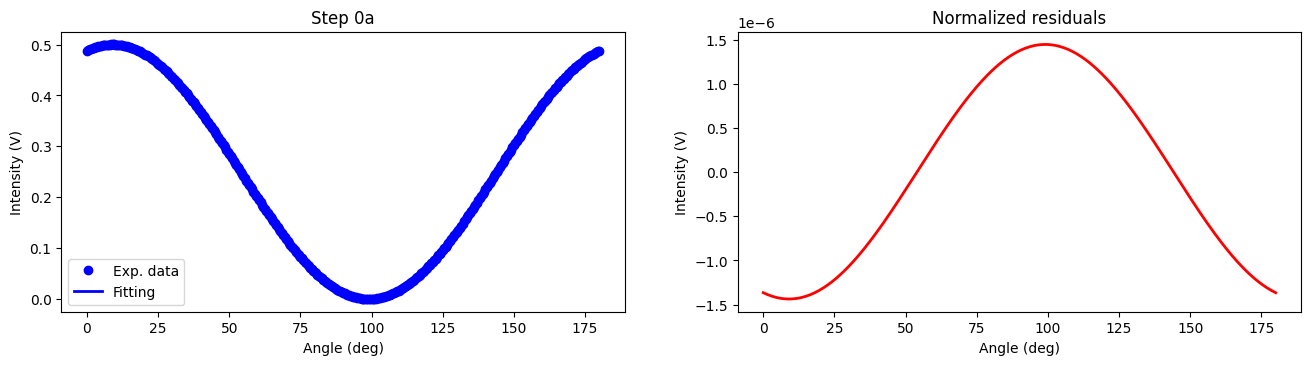

The normalized MSE is: 0.00 %.

The values obtained are:
   - Imax       : 0.5001 V
   - Imin       : 0.0001 V
   - Maximum angle : 9.01 deg


In [66]:
# Análisis paso 1a
result = cal.analyze_step(step = '0a', cal_dict = cal_dict, Iexp = Iexp_1a, angles = angles_1a, single = True)

In [15]:
# Guardado de los datos
I_1a = (result[0] + result[1])/Imax
cal_dict['P1_az'] = result[2] 

Segundo paso (1b): Polarizador de referencia y polarizador P2

In [16]:
# Medida experimental paso 1b
Mp2_rot = Mp2.rotate(angle=angles_def*degrees, keep=True)
Sf = (Mp2_rot * Mpc * S1)
Iexp_1b = Sf.parameters.intensity()
angles_1b = angles_def*degrees
cal_dict['I_step_1b'] = Iexp_1b
cal_dict['Angles_step_1b'] = angles_1b

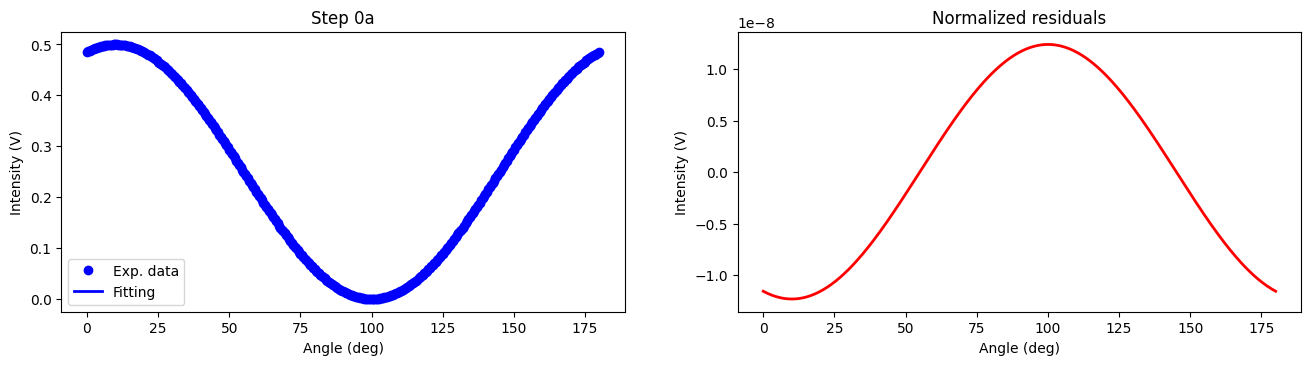

The normalized MSE is: 0.00 %.

The values obtained are:
   - Imax       : 0.5000 V
   - Imin       : 0.0002 V
   - Maximum angle : 10.00 deg


In [17]:
# Análisis paso 1b
result = cal.analyze_step(step = '0a', cal_dict = cal_dict, Iexp = Iexp_1b, angles = angles_1b, single = True)

In [18]:
# Guardado de los datos
I_1b = (result[0] + result[1])/Imax
cal_dict['P2_az'] = result[2] 

Tercer paso (1c): Polarizador P1 y polarizador P2

In [19]:
# Medida experimental paso 1c
Mp1_rot = Mp1.rotate(angle=cal_dict['P1_az'], keep=True)
Mp2_rot = Mp2.rotate(angle=angles_def*degrees, keep=True)
Sf = (Mp2_rot * Mp1_rot * S1)
Iexp_1c = Sf.parameters.intensity()
angles_1c = angles_def*degrees
cal_dict['I_step_1c'] = Iexp_1c
cal_dict['Angles_step_1c'] = angles_1c

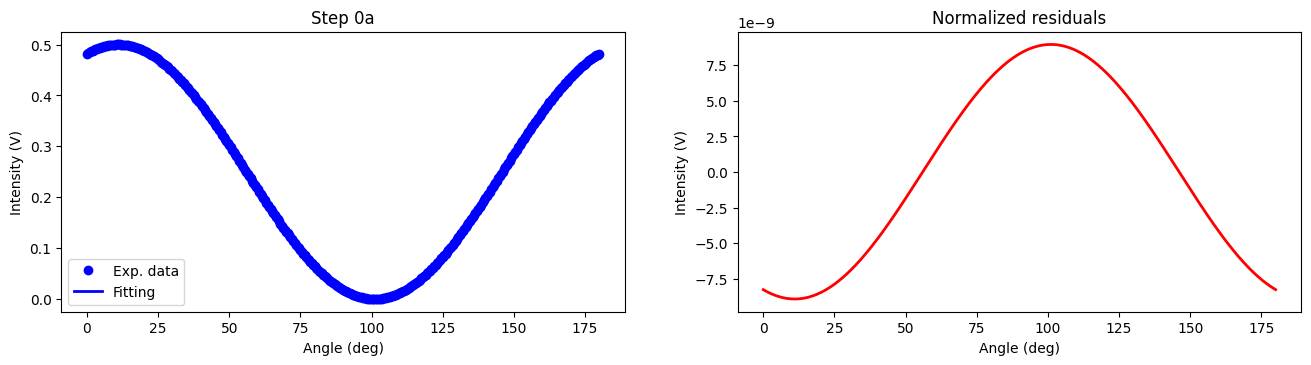

The normalized MSE is: 0.00 %.

The values obtained are:
   - Imax       : 0.5002 V
   - Imin       : 0.0003 V
   - Maximum angle : 10.99 deg


In [20]:
# Análisis paso 1c
result = cal.analyze_step(step = '0a', cal_dict = cal_dict, Iexp = Iexp_1c, angles = angles_1c, single = True)

In [21]:
# Guardado de los datos
I_1c = (result[0] + result[1])/Imax

Ahora calculamos los parámetros p1 de los tres polarizadores. Sobre todo, nos interesan los parámetros p1 de los polarizadores P1 y P2. Lo guardamos en el diccionario de datos

In [62]:
# Cálculo y guardado de los parámetros
print("Pc_p1: ", np.round(np.power((I_1a*I_1b)/(I_1c), 1/4),5))
print("P1_p1: ", np.round(np.power((I_1a*I_1c)/(I_1b), 1/4),5))
print("P2_p1: ", np.round(np.power((I_1b*I_1c)/(I_1a), 1/4),5))

cal_dict['Pc_p1'] = np.power((I_1a*I_1b)/(I_1c), 1/4)
cal_dict['P1_p1'] = np.power((I_1a*I_1c)/(I_1b), 1/4)
cal_dict['P2_p1'] = np.power((I_1b*I_1c)/(I_1a), 1/4)

Pc_p1:  0.99992
P1_p1:  1.00007
P2_p1:  1.00008


In [23]:
# Cálculo de p1 en el caso en el que P1 y P2 son iguales: Coger el paso 1c y despejar p1 usando una raiz cuarta
np.round(np.power((I_1c), 1/4),3)

1.0

---

## Paso 2: Medida del retardador Q2 y ajuste final de los parámetros de los polarizadores P1 y P2

A continuación, consideramos que los parámetros R y p2 de los polarizadores P1 y P2 son iguales. 

Mediante tres pasos de medidas de intensidad, podemos caracterizar de forma completa los polarizadores y los parámetros del retardador R2

### Paso 2a

Colocamos los polarizadores en su correspondiente azimut y rotamos 180º el retardador R2

In [24]:
# Medida experimental paso 2a
Mp1_rot = Mp1.rotate(angle=cal_dict['P1_az'], keep=True)
Mr2_rot = Mr2.rotate(angle=angles_def * degrees, keep=True)
Mp2_rot = Mp2.rotate(angle=cal_dict['P2_az'], keep=True)
Sf = (Mp2_rot * (Mr2_rot * (Mp1_rot * S1)))
Iexp_2a = Sf.parameters.intensity()
angles_2a = angles_def*degrees
cal_dict['I_step_2a'] = Iexp_2a
cal_dict['Angles_step_2a'] = angles_2a

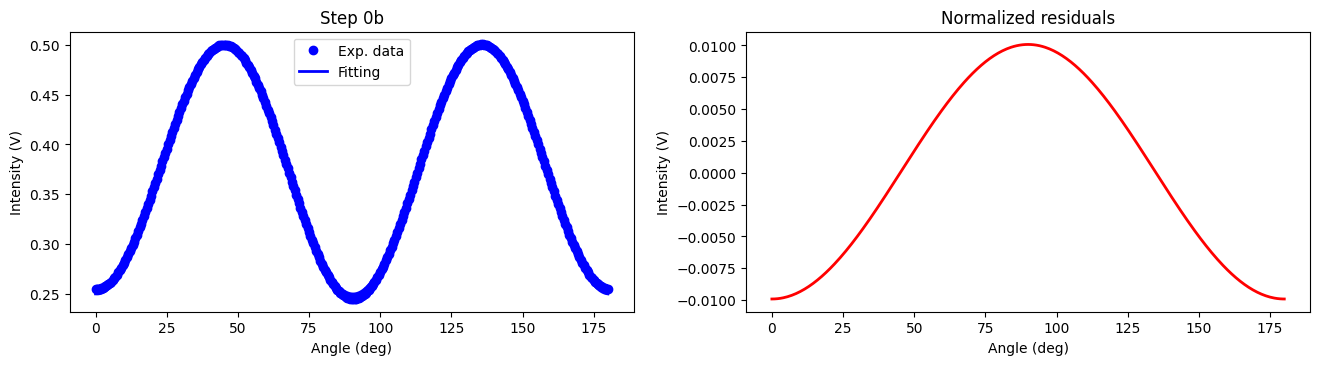

The normalized MSE is: 0.04 %.

The values obtained are:
   - Imax       : 0.5001 V
   - Imin       : 0.2502 V
   - Maximum angle : 45.50 deg

   - Azimuth angle:  45.496 degrees


In [25]:
# Análisis paso 2a
result = cal.analyze_step(step = '0b', cal_dict = cal_dict, Iexp = Iexp_2a, angles = angles_2a, single = True)
cal_dict['R2_az'] = result[2]
print("\n   - Azimuth angle: ", np.round(cal_dict['R2_az'] / degrees, 3), "degrees")

### Paso 2b

Ahora colocamos los polarizadores de nuevo en su correspondiente azimut y colocamos la lámina de referencia Rc a 45º con respecto a los azimut de los polarizadores. Luego, colocamos el retardador R2 y giramos 180º desde su azimut medido. 

Si el máximo se encuentra en torno a 45º, quiere decir que el eje medido en el retardador es el eje lento, lo cual hace falta añadir 90º al azimut medido previamente. No obstante, si el máximo se encuentra en torno a 135º, quiere decir que el eje medido en el retardador es el eje rápido, lo cual el azimut se mantiene. 

In [26]:
# Medida experimental paso 2b
Mp1_rot = Mp1.rotate(angle=cal_dict['P1_az'], keep=True)
Mr2_rot = Mr2.rotate(angle=angles_def * degrees + cal_dict['R2_az'], keep=True)
Mp2_rot = Mp2.rotate(angle=cal_dict['P2_az'], keep=True)
Sf = (Mp2_rot * (Mr2_rot * (Mrc * (Mp1_rot * S1))))
Iexp_2b = Sf.parameters.intensity()
angles_2b = angles_def*degrees
cal_dict['I_step_2b'] = Iexp_2b
cal_dict['Angles_step_2b'] = angles_2b

In [27]:
# Análisis paso 2b
result = cal.analyze_step(step = '0a', cal_dict = cal_dict, Iexp = Iexp_2b, angles = angles_2b, single = True)

The normalized MSE is: 0.04 %.

The values obtained are:
   - Imax       : 0.4968 V
   - Imin       : 0.0000 V
   - Maximum angle : 134.50 deg


In [28]:
# Actualizamos el valor de R2_az
if np.abs(result[2] - 45*degrees) < 15*degrees:
    cal_dict['R2_az'] = cal_dict['R2_az'] + 90*degrees
print("\n   - Azimuth angle after step 2b: ", np.round(cal_dict['R2_az'] / degrees, 3), "degrees")


   - Azimuth angle after step 2b:  45.496 degrees


### Paso 2c

Por último, quitamos el retardador R0 para tener una iluminación con polarización lineal a 45º. Después, se utiliza el valor de P0_az medido en el paso 0a del experimento para colocar los polarizadores a -45º con respecto al polarizador P0, de manera que los ángulos correspondientes son: 

- Ángulo de P1: P0_az - 45º
- Ángulo de P2: P0_az - 45º - P1_az + P2_az

Luego, colocamos el retardador R2 y quitamos el de referencia (Rc) y rotamos 180º a partir del ángulo correspondiente (alineados con los polarizadores): 
- Ángulo de R2 inicial: P0_az - 45º - P1_az + R2_az

Guardamos la medida para el análisis posterior

In [29]:
# Medida experimental paso 2c
angle_2c = cal_dict['P0_az'] - 45*degrees - cal_dict['P1_az']
Mp1_rot = Mp1.rotate(angle= cal_dict['P0_az']-45*degrees, keep=True)
Mr2_rot = Mr2.rotate(angle= angles_def * degrees+(angle_2c + cal_dict['R2_az']), keep=True)
Mp2_rot = Mp2.rotate(angle= angle_2c + cal_dict['P2_az'], keep=True)
Sf = (Mp2_rot * (Mr2_rot * (Mp1_rot * S0)))
Iexp_2c = Sf.parameters.intensity()
angles_2c = angles_def*degrees
cal_dict['I_step_2c'] = Iexp_2c
cal_dict['Angles_step_2c'] = angles_2c

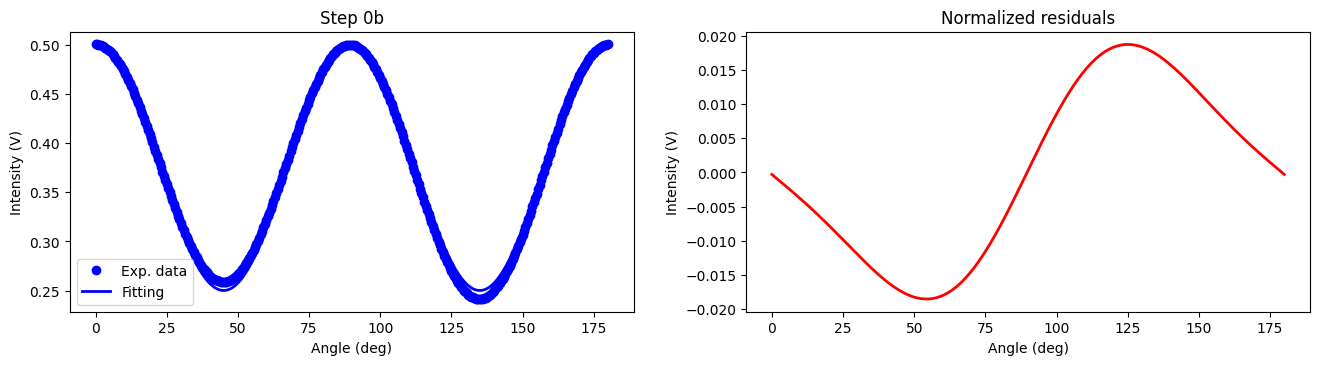

The normalized MSE is: 0.07 %.

The values obtained are:
   - Imax       : 0.5000 V
   - Imin       : 0.2502 V
   - Maximum angle : 0.00 deg


In [30]:
# Análisis paso 2c
result = cal.analyze_step(step = '0b', cal_dict = cal_dict, Iexp = Iexp_2c, angles = angles_2c, single = True)

### Análisis paso 2. Primer paso

El primer paso se basa en la teoría de la patente y del paper, en los cuales se afirma que la diferencia entre el segundo y el primer mínimo correspondientes a los pasos 2a y 2c (al rotar 180º el retardador, aparecen dos mínimos, que no tiene por qué ser iguales) están relacionados con la retardancia y el parámetro p2 del polarizador P1 (y, por ente, los parámetros de P2 equivalentes)

Calculamos los mínimos de los pasos 2a y 2c mediante un ajuste a una función polinómica de 2º grado

In [31]:
# Reordenado de los datos de la medida 2a
indice_ref = np.argmin(np.abs(angles_2a - cal_dict['R2_az']))
print('Indice de referencia I_2a: ', indice_ref)
Iexp_2a_r = np.concatenate((Iexp_2a[indice_ref:], Iexp_2a[:indice_ref]))

# Reordenado de los datos de la medida 2a
angle = cal_dict['P0_az'] - 45*degrees - cal_dict['P1_az'] + cal_dict['R2_az']
indice_ref = np.argmin(np.abs(angles_2a - angle_2c - cal_dict['R2_az']))
print('Indice de referencia I_2c: ', indice_ref)
Iexp_2c_r = np.concatenate((Iexp_2c[indice_ref:], Iexp_2c[:indice_ref]))


Indice de referencia I_2a:  91
Indice de referencia I_2c:  1


In [32]:
# Localización de los mínimos experimentales de I_2a y I_2c reordenados
arg_min_2a_1 = np.argmin(Iexp_2a_r[:len(Iexp_2a_r)//2])
arg_min_2a_2 = np.argmin(Iexp_2a_r[len(Iexp_2a_r)//2:]) + len(Iexp_2a_r)//2
arg_min_2c_1 = np.argmin(Iexp_2c_r[:len(Iexp_2c_r)//2])
arg_min_2c_2 = np.argmin(Iexp_2c_r[len(Iexp_2c_r)//2:]) + len(Iexp_2c_r)//2

In [33]:
# Cálculo de los dos mínimos de Iexp_2a a partir del ajuste
dist = 25
result = cal.analyze_step(step = 'polyfit', cal_dict = cal_dict, Iexp = Iexp_2a_r[arg_min_2a_1-dist:arg_min_2a_1+dist], angles = angles_2a[arg_min_2a_1-dist:arg_min_2a_1+dist], single = True, verbose = False)
min_2a_1 = (-result[1]**2)/(4*result[0]) + result[2]
print("min_2a_1: ", min_2a_1)

result = cal.analyze_step(step = 'polyfit', cal_dict = cal_dict, Iexp = Iexp_2a_r[arg_min_2a_2-dist:arg_min_2a_2+dist], angles = angles_2a[arg_min_2a_2-dist:arg_min_2a_2+dist], single = True, verbose = False)
min_2a_2 = (-result[1]**2)/(4*result[0]) + result[2]
print("min_2a_2: ", min_2a_2)

The values obtained are:
   - Coefficients: [ 0.95636275 -1.50177521  0.83493971]
min_2a_1:  0.24538078497577787
The values obtained are:
   - Coefficients: [ 0.90398309 -4.26785562  5.2923424 ]
min_2a_2:  0.255027046199821


In [34]:
# Cálculo de los dos mínimos de Iexp_2c a partir del ajuste
dist = 25
result = cal.analyze_step(step = 'polyfit', cal_dict = cal_dict, Iexp = Iexp_2c_r[arg_min_2c_1-dist:arg_min_2c_1+dist], angles = angles_2c[arg_min_2c_1-dist:arg_min_2c_1+dist], single = True, verbose = False)
min_2c_1 = (-result[1]**2)/(4*result[0]) + result[2]
print("min_2c_1: ", min_2c_1)

result = cal.analyze_step(step = 'polyfit', cal_dict = cal_dict, Iexp = Iexp_2c_r[arg_min_2c_2-dist:arg_min_2c_2+dist], angles = angles_2c[arg_min_2c_2-dist:arg_min_2c_2+dist], single = True, verbose = False)
min_2c_2 = (-result[1]**2)/(4*result[0]) + result[2]
print("min_2c_2: ", min_2c_2)

The values obtained are:
   - Coefficients: [ 0.92918047 -1.4366736   0.81441732]
min_2c_1:  0.25908089378973864
The values obtained are:
   - Coefficients: [ 0.96333877 -4.51556099  5.53333854]
min_2c_2:  0.24177038741604218


In [35]:
print("Diferencia de minimos 2a: ", min_2a_2 - min_2a_1)
print("Diferencia de minimos 2c: ", min_2c_2 - min_2c_1)

Diferencia de minimos 2a:  0.009646261224043107
Diferencia de minimos 2c:  -0.017310506373696466


In [36]:
# Cálculo de la retardancia del polarizador P1
cal_dict['P1_Ret'] = (np.arctan2((min_2c_2-min_2c_1),(min_2a_2-min_2a_1)))
cal_dict['P2_Ret'] = cal_dict['P1_Ret']
print('El valor de la retardancia del polarizador P1 es: ', np.round(cal_dict['P1_Ret']/degrees, 3), '°')

El valor de la retardancia del polarizador P1 es:  -60.871 °


In [37]:
# Cálculo del parámetro p2 del polarizador P1
P1_p2_1 = (min_2a_2-min_2a_1) / (cal_dict['S1']*cal_dict['P1_p1']*np.cos(cal_dict['P1_Ret'])*cal_dict['P2_p1']**2)
P1_p2_2 = (min_2c_2-min_2c_1) / (cal_dict['S1']*cal_dict['P1_p1']*np.sin(cal_dict['P1_Ret'])*cal_dict['P2_p1']**2)
# Put 0 if nan
if np.isnan(P1_p2_1): # Check
    P1_p2_1 = 0
if np.isnan(P1_p2_2): # Check
    P1_p2_2 = 0
print("P1_p2_1: ", P1_p2_1, "P1_p2_2: ", P1_p2_2)

P1_p2_1:  0.019812298096531965 P1_p2_2:  0.01981229809653197


In [38]:
# Cálculo de parámetro p2 del polarizador P1
P1_p2 = P1_p2_1
cal_dict['P1_p2'] = P1_p2
cal_dict['P2_p2'] = P1_p2
print('El valor de p2 del polarizador P1 es: ', np.round(cal_dict['P1_p2'], 3))

El valor de p2 del polarizador P1 es:  0.02


### Análisis paso 2. Segundo paso

El segundo paso se basa en un ajuste con py-pol de los parámetros del retardador R2

In [39]:
# Cálculo de los parámetros del retardador R2
result = cal.analyze_step(step = '2', cal_dict = cal_dict, single = True)[0]
print('R2_p1:', result[0])
print('R2_p2:', result[1])
print('R2_Ret:', result[2]/degrees)
print('R2_az:', result[3]/degrees)

R2_p1: 0.9996741017569163
R2_p2: 0.9994381016171285
R2_Ret: 89.9315072949583
R2_az: 0.005283779777798087


In [39]:
# Guardado de los datos
cal_dict['R2_p1'] = result[0]
cal_dict['R2_p2'] = result[1]
cal_dict['R2_Ret'] = result[2]
cal_dict['R2_az'] = result[3] + cal_dict['R2_az']

### Análisis paso 2. Método global

Ajuste con py-pol de los resultados y caracterizando todos los parámetros

In [40]:
# Cálculo de los parámetros del retardador R2
result = cal.analyze_step(step = '2_global', cal_dict = cal_dict, single = True)[0]
print('P1_p2:', result[0])
print('P1_Ret:', result[1]/degrees)
print('R2_p1:', result[2])
print('R2_p2:', result[3])
print('R2_Ret:', result[4]/degrees)
print('R2_az:', result[5]/degrees)

P1_p2: 0.020001602499227274
P1_Ret: 59.999503072930295
R2_p1: 0.9998505826195534
R2_p2: 0.9998505730831657
R2_Ret: 89.99997544526315
R2_az: -0.4963103885553705


In [41]:
# Guardado de los datos
cal_dict['P1_p2'] = result[0]
cal_dict['P1_Ret'] = result[1]
cal_dict['R2_p1'] = result[2]
cal_dict['R2_p2'] = result[3]
cal_dict['R2_Ret'] = result[4]
cal_dict['R2_az'] = result[5] + cal_dict['R2_az']

---

## Paso 3: Caracterización de la fuente de iluminación

Ahora caracterizamos la iluminación mediante polarimetría de Stokes. Utilizamos el retardador R2 y el polarizador P2

In [44]:
# Medida experimental paso 3
angles = utils.PSA_states_2_angles(S = utils.S_20)
Mr2_rot = Mr2.rotate(angle=cal_dict['R2_az']+angles[1], keep=True)
Mp2_rot = Mp2.rotate(angle=cal_dict['P2_az']+angles[0], keep=True)
Sf = (Mp2_rot * (Mr2_rot * S1))
Iexp_3 = Sf.parameters.intensity()
angles_3 = np.array(angles)
angles_3[0] += cal_dict['P2_az']
angles_3[1] = angles[1] + cal_dict['R2_az']
cal_dict['I_step_3'] = Iexp_3
cal_dict['Angles_step_3'] = angles_3

In [45]:
# Análisis paso 3
result = cal.analyze_step(step = '3', cal_dict = cal_dict, Iexp = Iexp_3, angles = angles_3, single = True)

Azimuth:  0.0
Intensidad:  1.0001561645855923
Ángulo de elipticidad:  44.99999999999999
Grado de polarización:  0.9999848042


In [46]:
# Guardado de los datos
cal_dict['illum_az'] = result[0]
cal_dict['illum_el'] = result[1]
cal_dict['illum_pol_degree'] = result[2]

---

## Paso 4: Medida del retardador Q1 

El paso es equivalente al paso 2, pero sustituyendo el retardador R2 por el retardador R1

Mediante tres pasos de medidas de intensidad, podemos caracterizar de forma completa los parámetros del retardador R1

### Paso 4a

Colocamos los polarizadores en su correspondiente azimut y rotamos 180º el retardador R1

In [47]:
# Medida experimental paso 4a
Mp1_rot = Mp1.rotate(angle=cal_dict['P1_az'], keep=True)
Mr1_rot = Mr1.rotate(angle=angles_def * degrees, keep=True)
Mp2_rot = Mp2.rotate(angle=cal_dict['P2_az'], keep=True)
Sf = (Mp2_rot * (Mr1_rot * (Mp1_rot * S1)))
Iexp_4a = Sf.parameters.intensity()
angles_4a = angles_def*degrees
cal_dict['I_step_4a'] = Iexp_4a
cal_dict['Angles_step_4a'] = angles_4a

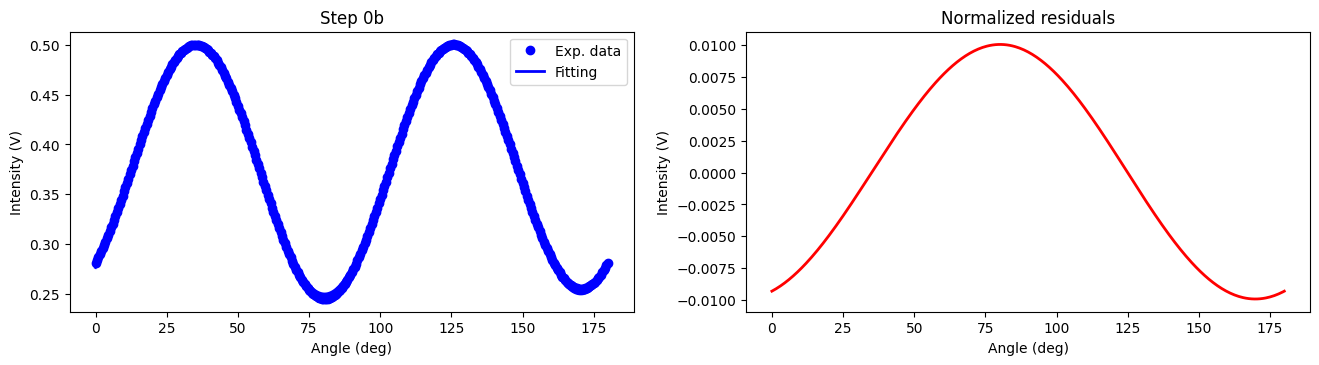

The normalized MSE is: 0.04 %.

The values obtained are:
   - Imax       : 0.5001 V
   - Imin       : 0.2502 V
   - Maximum angle : 35.49 deg

   - Azimuth angle:  35.494 degrees


In [48]:
# Análisis paso 4a
result = cal.analyze_step(step = '0b', cal_dict = cal_dict, Iexp = Iexp_4a, angles = angles_4a, single = True)
cal_dict['R1_az'] = result[2]
print("\n   - Azimuth angle: ", np.round(cal_dict['R1_az'] / degrees, 3), "degrees")

### Paso 4b

Ahora colocamos los polarizadores de nuevo en su correspondiente azimut y colocamos la lámina de referencia Rc a 45º con respecto a los azimut de los polarizadores. Luego, colocamos el retardador R1 y giramos 180º desde su azimut medido. 

Si el máximo se encuentra en torno a 45º, quiere decir que el eje medido en el retardador es el eje lento, lo cual hace falta añadir 90º al azimut medido previamente. No obstante, si el máximo se encuentra en torno a 135º, quiere decir que el eje medido en el retardador es el eje rápido, lo cual el azimut se mantiene. 

In [52]:
# Medida experimental paso 4b
Mp1_rot = Mp1.rotate(angle=cal_dict['P1_az'], keep=True)
Mr1_rot = Mr1.rotate(angle=angles_def * degrees + cal_dict['R1_az'], keep=True)
Mp2_rot = Mp2.rotate(angle=cal_dict['P2_az'], keep=True)
Sf = (Mp2_rot * (Mr1_rot * (Mrc * (Mp1_rot * S1))))
Iexp_4b = Sf.parameters.intensity()
angles_4b = angles_def*degrees
cal_dict['I_step_4b'] = Iexp_4b
cal_dict['Angles_step_4b'] = angles_4b

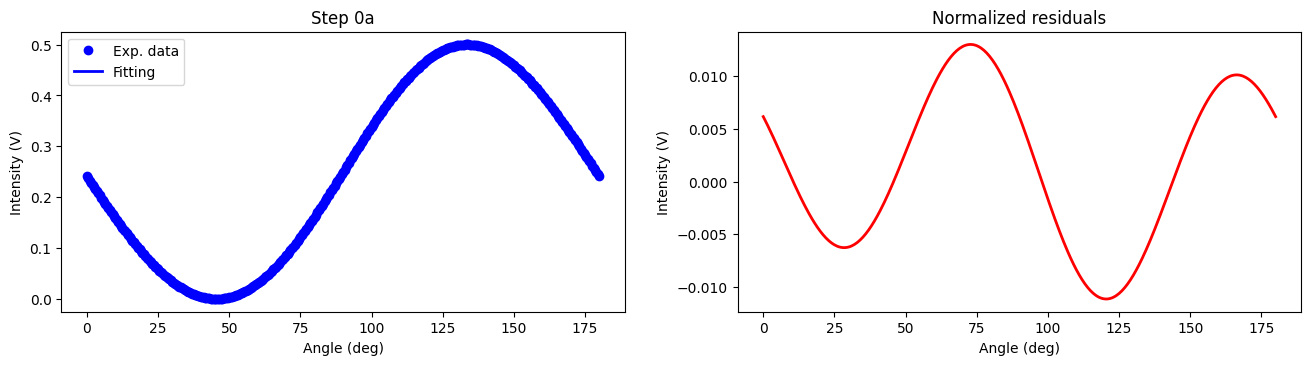

The normalized MSE is: 0.04 %.

The values obtained are:
   - Imax       : 0.4968 V
   - Imin       : 0.0000 V
   - Maximum angle : 134.50 deg


In [54]:
# Análisis paso 4b
result = cal.analyze_step(step = '0a', cal_dict = cal_dict, Iexp = Iexp_4b, angles = angles_4b, single = True)

In [55]:
# Actualizamos el valor de R1_az
if np.abs(result[2] - 45*degrees) < 5*degrees:
    cal_dict['R1_az'] = cal_dict['R1_az'] + 90*degrees
print("\n   - Azimuth angle after step 4b: ", np.round(cal_dict['R1_az'] / degrees, 3), "degrees")


   - Azimuth angle after step 4b:  35.494 degrees


### Paso 4c

Por último, quitamos el retardador R0 para tener una iluminación con polarización lineal a 45º. Después, se utiliza el valor de P0_az medido en el paso 0a del experimento para colocar los polarizadores a -45º con respecto al polarizador P0, de manera que los ángulos correspondientes son: 

- Ángulo de P1: P0_az - 45º
- Ángulo de P2: P0_az - 45º - P1_az + P2_az

Luego, colocamos el retardador R1 y quitamos el de referencia (Rc) y rotamos 180º a partir del ángulo correspondiente (alineados con los polarizadores): 
- Ángulo de R2 inicial: P0_az - 45º - P1_az + R1_az

Guardamos la medida para el análisis posterior

In [56]:
# Medida experimental paso 4c
angle_4c = cal_dict['P0_az'] - 45*degrees - cal_dict['P1_az']
Mp1_rot = Mp1.rotate(angle= cal_dict['P0_az']-45*degrees, keep=True)
Mr1_rot = Mr1.rotate(angle= angles_def * degrees+(angle_4c + cal_dict['R1_az']), keep=True)
Mp2_rot = Mp2.rotate(angle= angle_2c + cal_dict['P2_az'], keep=True)
Sf = (Mp2_rot * (Mr1_rot * (Mp1_rot * S0)))
Iexp_4c = Sf.parameters.intensity()
angles_4c = angles_def*degrees
cal_dict['I_step_4c'] = Iexp_4c
cal_dict['Angles_step_4c'] = angles_4c

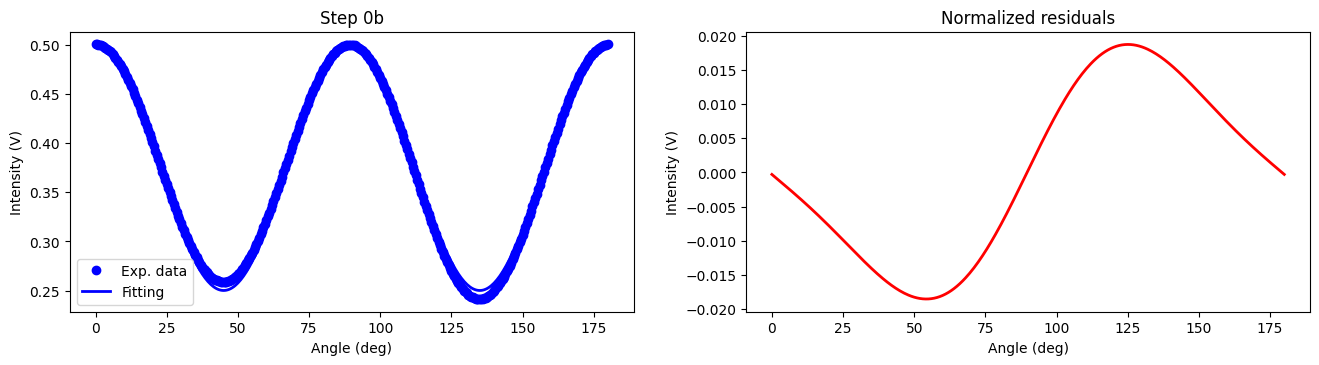

The normalized MSE is: 0.07 %.

The values obtained are:
   - Imax       : 0.5000 V
   - Imin       : 0.2502 V
   - Maximum angle : 0.00 deg


In [57]:
# Análisis paso 4c
result = cal.analyze_step(step = '0b', cal_dict = cal_dict, Iexp = Iexp_4c, angles = angles_4c, single = True)

### Análisis paso 4. Segundo paso

El segundo paso se basa en un ajuste con py-pol de los parámetros del retardador R1

In [58]:
# Cálculo de los parámetros del retardador R2
result = cal.analyze_step(step = '4', cal_dict = cal_dict, single = True)[0]
print('R1_p1:', result[0])
print('R1_p2:', result[1])
print('R1_Ret:', result[2]/degrees)
print('R1_az:', result[3]/degrees)

R1_p1: 0.9998499624738029
R1_p2: 0.9998499567286616
R1_Ret: 89.99992216006878
R1_az: -0.4943683170672077


In [59]:
# Guardado de los datos
cal_dict['R1_p1'] = result[0]
cal_dict['R1_p2'] = result[1]
cal_dict['R1_Ret'] = result[2]
cal_dict['R1_az'] = result[3] + cal_dict['R1_az']

---

## Paso 5: Matriz de Mueller del aire

Por último, para comprobar que el procedimiento de calibración realizado es correcto, colocamos el retardador R0 y los 4 elementos ópticos conocidos sus parámetros: 
- Polarizador P1
- Retardador R1
- Retardador R2
- Polarizador P2

Medimos con una configuración de ángulos perfectos de 144 ángulos


In [60]:
# Medida experimental paso 5
angles = utils.calculate_polarimetry_angles(144, type='perfect')
Mr1_rot = Mr1.rotate(angle=cal_dict['R1_az']+angles[:,1], keep=True)
Mp1_rot = Mp1.rotate(angle=cal_dict['P1_az']+angles[:,0], keep=True)
Mr2_rot = Mr2.rotate(angle=cal_dict['R2_az']+angles[:,2], keep=True)
Mp2_rot = Mp2.rotate(angle=cal_dict['P2_az']+angles[:,3], keep=True)
Sf = (Mp2_rot * (Mr2_rot *(Mr1_rot * (Mp1_rot * S1))))
Iexp_5 = Sf.parameters.intensity()
angles_5 = np.array(angles)
angles_5[:,0] += cal_dict['P1_az']
angles_5[:,1] += cal_dict['R1_az']
angles_5[:,2] += cal_dict['R2_az']
angles_5[:,3] += cal_dict['P2_az']
cal_dict['I_step_5'] = Iexp_5
cal_dict['Angles_step_5'] = angles_5

In [61]:
# Análisis paso 5 - Medida de la matriz de Mueller del aire
M = cal.analyze_step(step = '5', cal_dict = cal_dict, Iexp = Iexp_5, angles = angles_5, single = True)

The Mueller matrix is:
 M = 
[+1.000 -0.000 -0.000 +0.000]   
[+0.000 +0.999 +0.025 -0.000]   
[+0.000 -0.022 +0.999 -0.000]   
[-0.027 +0.000 -0.000 +1.000]   



---

## Final de la Calibración

In [ ]:
# Impesión de los resultados
cal.Print_Cal_Files(cal_dict, wavelength=wavelength)

In [158]:
# Guardado de los archivos
cal.Save_Cal_Files(cal_dict = cal_dict, filename = 'individual')

---